In [3]:
from fealpy.functionspace import LagrangeFiniteElementSpace
from fealpy.mesh import MeshFactory
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.sparse.linalg import spsolve
from fealpy.boundarycondition import DirichletBC, NeumannBC

from fealpy.tools.show import showmultirate, show_error_table


In [4]:
import numpy as np
from fealpy.decorator import cartesian,barycentric
class possion_solution:
    
    def __init__(self):
        pass
    
    # 定义网格区域大小
    @property
    def domain(self):   
        return np.array([0, 18, 0, 7])
        
    # 原项 f(x,y)，泊松方程的右边
    @cartesian
    def source(self, p):  
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = 2*pi*pi*np.cos(pi*x)*np.cos(pi*y)
        return val
    
    # 精确解u(x,y)，泊松方程的左边
    @cartesian
    def exact_solution(self, p):
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = np.cos(pi*x)*np.cos(pi*y)
        return val
        
    # 真解的梯度 
    @cartesian
    def gradient(self, p):  
        x = p[..., 0]
        y = p[..., 1]
        pi = np.pi
        val = np.zeros(p.shape, dtype = np.float64)
        val[..., 0] = -pi*np.sin(pi*x)*np.cos(pi*y)
        val[..., 1] = -pi*np.cos(pi*x)*np.sin(pi*y)
        return val
        
    # 梯度的负方向
    @cartesian 
    def flux(self, p):
        return -self.gradient(p)
        
    #定义边界条件
    @cartesian
    def is_dirichlet_boundary(self, p):
        y = p[..., 1]
        return (y == 0.0) 
    
    @cartesian
    def dirichlet(self, p):
        return self.exact_solution(p)
    
    @cartesian
    def is_neumann_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        return (x == 0.0)|(x == 0.1)|(y == 0.1)
        
    @cartesian
    def neumann(self, p, n):
        grad = self.gradient(p)
        val = np.sum(grad * n, axis = -1)
        return val


run boxmesh2d with time: 0.0005579000000004442


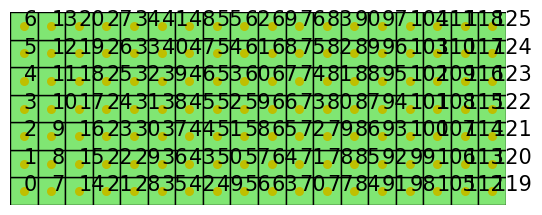

In [5]:
import numpy as np
from fealpy.mesh import MeshFactory
import matplotlib.pyplot as plt
%matplotlib inline

# 加载pde模型
pde = possion_solution()

# 加载网格
box = pde.domain
mesh = MeshFactory.boxmesh2d(box, nx = 18, ny = 7, meshtype = 'quad')

# 画图
figure = plt.figure()
axes = figure.gca()
mesh.add_plot(axes)
#mesh.find_node(axes, showindex = True)
#mesh.find_edge(axes, showindex = True)
mesh.find_cell(axes, showindex = True)

#获取单元，网格，节点信息
nodes = mesh.entity('node')
cells = mesh.entity('cell')
edges = mesh.entity('edge')


In [8]:
import sys
def possion_solution_solver(pde, n, refine, order): 
    """
    Input:
        @pde: 定义偏微分方程
        @n: 初始网格剖分段数
        @refine: 网格加密的最大次数（迭代求解次数）
        @order: 有限元多项式次数
    Output: None
    """
    mesh = MeshFactory.boxmesh2d(pde.domain, nx = n, ny = n, meshtype = 'tri')
    
    number_of_dofs = np.zeros(refine, dtype = mesh.itype)
    # 建立空数组，目的把每组的自由度个数存下来
    error_matrix = np.zeros((2, refine), dtype = mesh.ftype)
    error_type = ['$||u - u^{h}||_{0}$', '$||\\nabla u - \\nabla u^{h}||_{0}$']
    
    for i in range(refine):
        femspace = LagrangeFiniteElementSpace(mesh, p = order)
        number_of_dofs[i] = femspace.number_of_global_dofs()
        uh = femspace.function() 
        # 返回一个有限元函数，初始自由度值全为 0
        
        # A·u = b + b_n
        
        A = femspace.stiff_matrix()
        F = femspace.source_vector(pde.source)
        # 先计算纽曼
        bc = NeumannBC(femspace, pde.neumann, threshold = pde.is_neumann_boundary)
        F = bc.apply(F)
        
        #最后计算Dirichlet
        bc = DirichletBC(femspace, pde.dirichlet, threshold = pde.is_dirichlet_boundary)
        A, F = bc.apply(A, F, uh)
        
        uh[:] = spsolve(A, F)
        
        #计算误差
        error_matrix[0, i] = femspace.integralalg.L2_error(pde.exact_solution, uh.value)
        error_matrix[1, i] = femspace.integralalg.L2_error(pde.gradient, uh.grad_value)
        
        print('插值点: ', femspace.interpolation_points().shape)
        print('自由度数（NDof）: ', number_of_dofs[i])
        nodes = mesh.entity('node')
        print('节点数: ', nodes.shape)
        if i < refine - 1:
            mesh.uniform_refine()
    
    fig = plt.figure()
    axes = fig.add_subplot(projection='3d')
    uh.add_plot(axes, cmap = 'rainbow')
    showmultirate(plt, 0, number_of_dofs, error_matrix, error_type, propsize = 20)
    show_error_table(number_of_dofs, error_type, error_matrix, f='e', pre=4, sep=' & ', out=sys.stdout, end='\n')
    plt.show()


run boxmesh2d with time: 0.0006658000000001607
run serial_construct_matrix with time: 0.0032850999999993746
插值点:  (121, 2)
自由度数（NDof）:  121
节点数:  (121, 2)
run serial_construct_matrix with time: 0.010370299999998167
插值点:  (441, 2)
自由度数（NDof）:  441
节点数:  (441, 2)
run serial_construct_matrix with time: 0.03749090000000166
插值点:  (1681, 2)
自由度数（NDof）:  1681
节点数:  (1681, 2)
run serial_construct_matrix with time: 0.15884780000000376
插值点:  (6561, 2)
自由度数（NDof）:  6561
节点数:  (6561, 2)
run serial_construct_matrix with time: 0.6029596000000055
插值点:  (25921, 2)
自由度数（NDof）:  25921
节点数:  (25921, 2)
\begin{table}[!htdp]
\begin{tabular}[c]{|c|c|c|c|c|c|}\hline
Dof &   121 &   441 &  1681 &  6561 & 25921
\\\hline
$||u - u^{h}||_{0}$ & 6.5579e+00 & 4.0887e+00 & 1.5592e+00 & 4.3673e-01 & 1.1237e-01
\\\hline
Order & -- & 0.68 & 1.39 & 1.84 & 1.96
\\\hline
$||\nabla u - \nabla u^{h}||_{0}$ & 2.4868e+01 & 2.0686e+01 & 1.2484e+01 & 6.5705e+00 & 3.3285e+00
\\\hline
Order & -- & 0.27 & 0.73 & 0.93 & 0.98
\\\hli

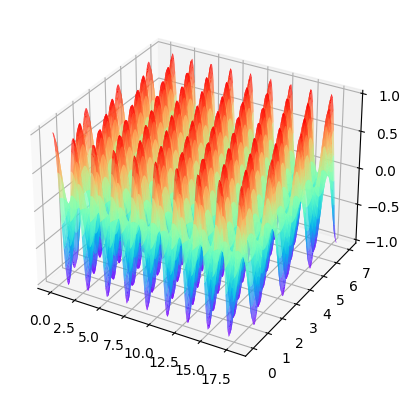

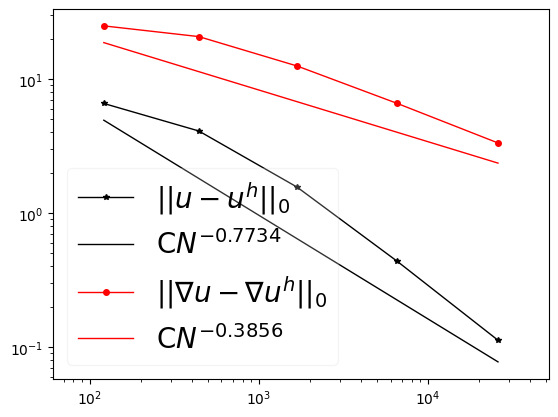

In [9]:
possion_solution_solver(possion_solution(), 10, 5, 1)


run boxmesh2d with time: 0.0024063000000751344
run serial_construct_matrix with time: 0.01062530000035622
插值点:  (441, 2)
自由度数（NDof）:  441
节点数:  (121, 2)
run serial_construct_matrix with time: 0.033455899999808025
插值点:  (1681, 2)
自由度数（NDof）:  1681
节点数:  (441, 2)
run serial_construct_matrix with time: 0.13422859999991488
插值点:  (6561, 2)
自由度数（NDof）:  6561
节点数:  (1681, 2)
run serial_construct_matrix with time: 0.534031799999866
插值点:  (25921, 2)
自由度数（NDof）:  25921
节点数:  (6561, 2)
run serial_construct_matrix with time: 2.3043808000002173
插值点:  (103041, 2)
自由度数（NDof）:  103041
节点数:  (25921, 2)


E:\Anaconda3\envs\school\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


\begin{table}[!htdp]
\begin{tabular}[c]{|c|c|c|c|c|c|}\hline
Dof &    441 &   1681 &   6561 &  25921 & 103041
\\\hline
$||u - u^{h}||_{0}$ & 4.1804e+00 & 8.2452e-01 & 1.0930e-01 & 1.4458e-02 & 1.8436e-03
\\\hline
Order & -- & 2.34 & 2.92 & 2.92 & 2.97
\\\hline
$||\nabla u - \nabla u^{h}||_{0}$ & 2.0033e+01 & 8.2023e+00 & 2.4225e+00 & 6.3776e-01 & 1.6167e-01
\\\hline
Order & -- & 1.29 & 1.76 & 1.93 & 1.98
\\\hline
\end{tabular}
\end{table}


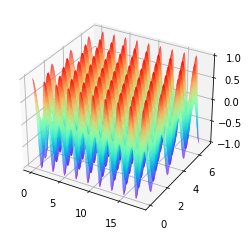

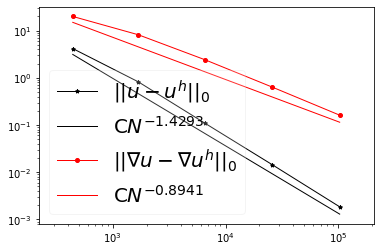

In [19]:
# possion_solution_solver(possion_solution(), 10, 5, 2)


In [21]:
def is_dirichlet_boundary(self, p):
        x = p[..., 0]
        y = p[..., 1]
        return (y == 0.0) & ( x <b) & (x > a) 
    
@cartesian
def dirichlet(self, p):
    val = val * np.ones(len(p))
    return val


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)